# Q学習
行動価値関数
$$
Q(s,a)=\mathrm{E}\left[\sum_{\tau=0}^\infty \gamma^\tau r_{t+\tau}\ \middle|\ s_t=s,a_t=a\right]
$$
の推定値$\hat{Q}$に基づいて行動を選択しつつ，その経験に基づいて$\hat{Q}$を更新して行く手法．

In [38]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# OpenAI Gymのインポート
import gym

def run_simulation(env, step_fn):
    fig = plt.figure()
    array = env.render(mode='rgb_array')
    im = plt.imshow(array, animated=True)
    plt.xticks([])
    plt.yticks([])
    text = plt.text(10,array.shape[0]-10,'')

    def update(*args):
        info = step_fn()
        im.set_array(env.render(mode='rgb_array'))
        text.set_text(info)
        return im, text
    
    global _ani
    _ani = animation.FuncAnimation(fig, update, interval=50, blit=True)
    plt.show()
    
# ε-グリーディ（下記参照）
def epsilon_greedy(Q, epsilon):
    rand = np.random.rand()
    if rand < epsilon:
        inds = np.arange(len(Q))
    else:
        i = np.argmax(Q)
        inds, = np.where(Q == Q[i])
    return np.random.choice(inds)

# ボルツマン選択（下記参照）
def boltzmann_selection(Q, T):
    Q = Q/T
    Q = Q - np.max(Q) # to prevent overflow
    P = np.exp(Q)
    cum = np.cumsum(P)
    right = cum/cum[-1]
    left = np.concatenate([[0.], right[:-1]])
    rand = np.random.rand()
    try:
        action = np.where(np.logical_and(left <= rand, rand < right))[0][0]
    except:
        raise ValueError(str([Q,cum,P,right,left]))
    return action

env = gym.make('CartPole-v0')

## 行動選択
探索と搾取のバランスを取るため，$\hat{Q}$が大きい行動の頻度は高いが，それ以外の行動も時々選ばれるように，確率的に選択する．
現在の状態が$s$のとき，$\hat{Q}(s,\cdot)$に基づいて行動$a$が選択される確率を決める．
以下の方法がよく用いられる．

### $\varepsilon$-グリーディ法
小さい確率$0<\varepsilon\ll 1$で選択し得る全ての行動からランダムに選択（探索），それ以外の場合は$\hat{Q}(s,a)$が最大となる$a$（最適行動）を選択する（搾取）．
最適行動を取る確率は$\varepsilon/{|\mathcal{A}|}+(1-\varepsilon)$，それ以外の行動を取る確率は$\varepsilon/{|\mathcal{A}|}$となる．

### ボルツマン選択（ソフトマックス法）
ボルツマン分布に従って行動を選択する．
$$\pi(s,a)=P(a\mid s)=\frac{\exp(\hat{Q}(s,a)/T)}{\sum_{a'}\exp(\hat{Q}(s,a')/T)}$$
$T>0$は温度と呼ばれ，大きい時は最適行動が選択されやすくなり（搾取傾向），小さい時は$\hat{Q}$の値に依らずランダムな選択（探索傾向）となる．

<IPython.core.display.Javascript object>


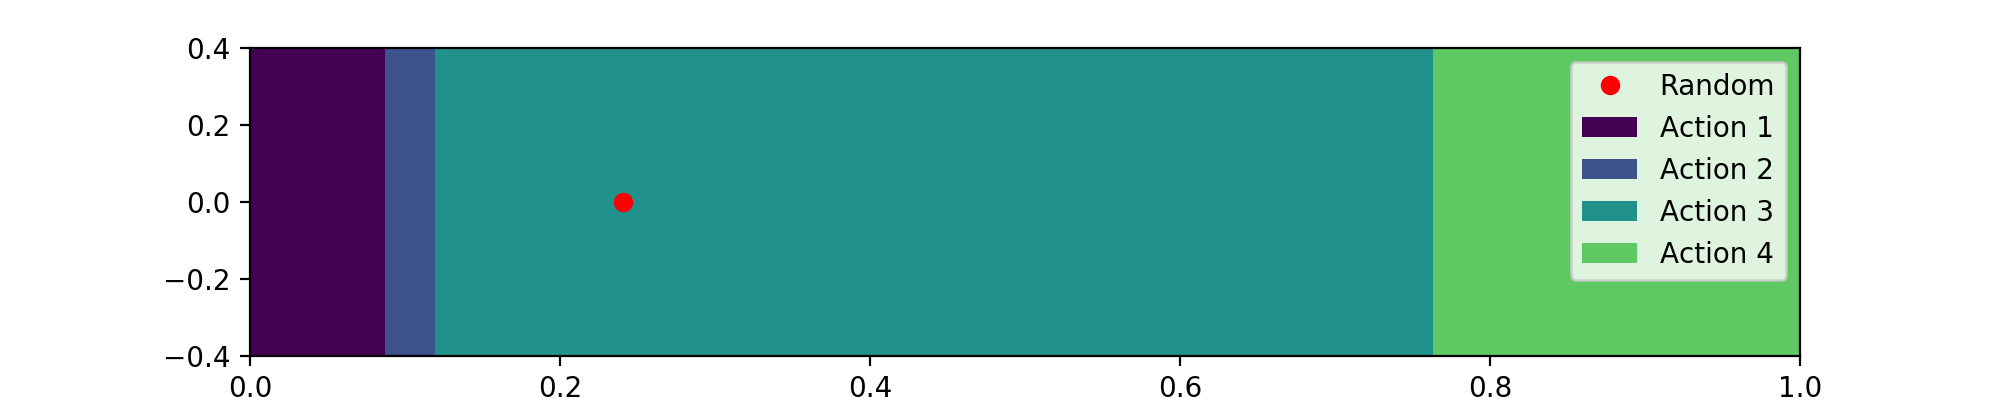

Action 3 was selected.


In [39]:
# ボルツマン選択の可視化s

# ある状態sに対する行動価値関数Q(s,・)
Q = np.array([2,1,4,3])
T = 1.

P = np.exp(Q/T)
P /= np.sum(P)
right = np.cumsum(P)
left = np.concatenate([[0.], right[:-1]])
rand = np.random.rand()
action = np.where(np.logical_and(rand >= left, rand < right))[0][0]

plt.figure(u'ボルツマン選択', figsize=(10,2))
for i, p in enumerate(P):
    color = plt.cm.viridis(float(i) / len(P), 1)
    plt.barh(0, p, left=left[i], color=color, label='Action %d'%(i+1))
plt.plot(rand, 0., 'ro', label='Random')
plt.xlim([0,1])
plt.ylim([-.4,.4])
plt.legend()
plt.show()

print('Action %d was selected.' % (action+1))

## 手動で設計した行動価値関数を用いた行動選択（倒立振子）
CartPole-v0の場合，行動価値関数は$Q\left((x,\dot{x},\theta,\dot{\theta})^\top,a\right)$のように合計5つのパラメータを持つ関数である．しかし$a$は$0$か$1$の二値なので，$Q\left((x,\dot{x},\theta,\dot{\theta})^\top,0\right),Q\left((x,\dot{x},\theta,\dot{\theta})^\top,1\right)$のように4つのパラメータを持つ関数を二つ用意すればよい．

ここで倒立振子を制御できそうな行動価値関数を手動で設計し，これを用いて行動選択をしてみる．
振子が右に傾いている（$\theta$>0）時に台車を右に加速する（a=1）価値が高そう（そして逆も成り立ちそう）なので， 適当な定数$w>0$を決めて
$$
\hat{Q}\left((x,\dot{x},\theta,\dot{\theta})^\top,0\right)=-w \theta,\\ \hat{Q}\left((x,\dot{x},\theta,\dot{\theta})^\top,1\right)=w \theta
$$
としてみる．

<IPython.core.display.Javascript object>


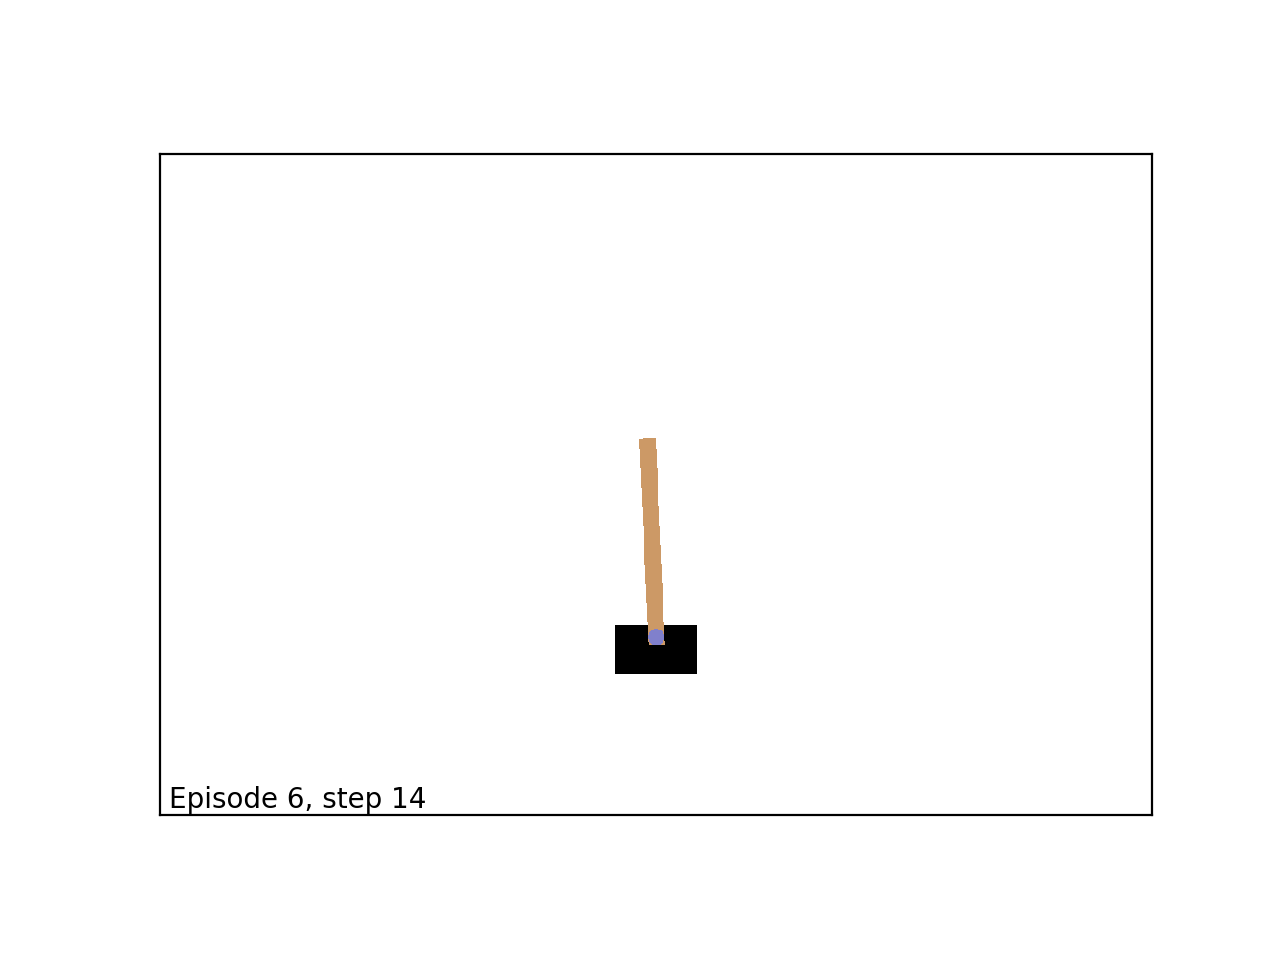

In [40]:
# 行動価値関数Q(s,・)
def Q(state):
    w = 0.5
    x, x_dot, theta, theta_dot = state
    return np.array([-w * theta, w * theta])

state = env.reset()

episode = 1
t = 0

def step():
    global state, episode, t
    q = Q(state)
    action = epsilon_greedy(q, 0.1)
    state,_,done,_ = env.step(action)
    t += 1
    if done:
        env.reset()
        episode += 1
        t = 0
    return 'Episode {}, step {}'.format(episode, t)

run_simulation(env, step)

## 状態が有限通りの場合
状態が$s\in\{s_1,s_2,\cdots,s_n\}$のように有限通りしかない場合（そして行動もこれまで通り有限通りの場合），
行動価値関数は
$Q(s_i,a_j)=Q_{ij}$のように二次元配列で表現できる．
Q学習の適用範囲としては，連続値の状態を持つ環境，有限個の状態を持つ環境のどちらの適用例も多数みられるが，後者の方が簡単で計算コストも低いので，以降では後者について解説する．
OpenAI Gymでは有限個の状態を持つ環境（FrozenLake-v0など）も提供されているが，
ここでは$\theta$を離散化することで，CartPole-v0を有限状態の環境に近似する．さらに，しばらくの間，$\theta$以外の状態変数を無視する（正確にはPOMDPとなるが，近似的にMDPとみなして進める）．

<IPython.core.display.Javascript object>


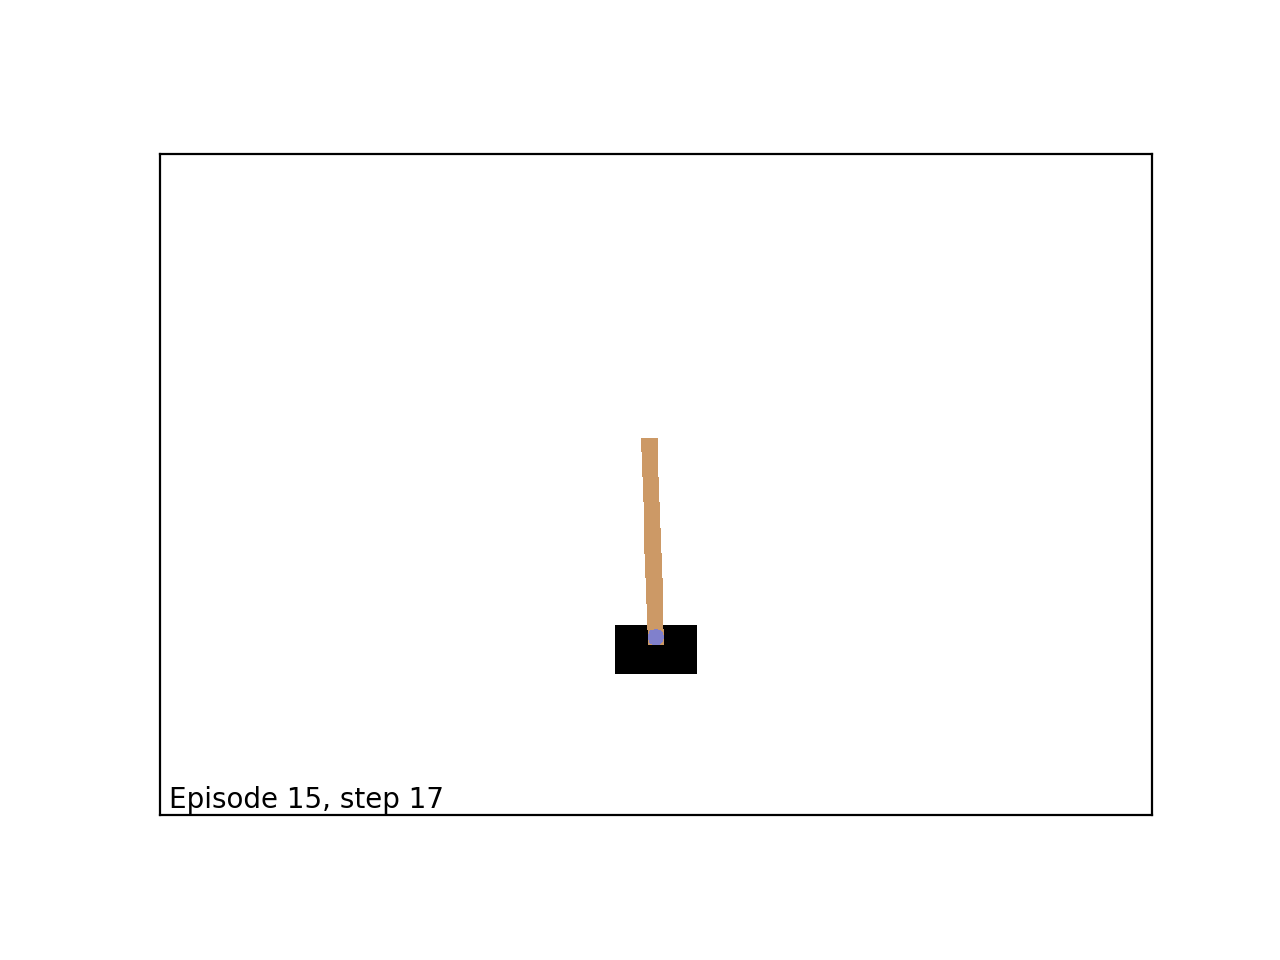

In [44]:
# 離散版の行動価値関数（Qテーブル）
Q = np.array([[0.5, -0.5],
              [0.3, -0.3],
              [0.1, -0.1],
              [-0.1, 0.1],
              [-0.3, 0.3],
              [-0.5, 0.5]])

# valを離散化する
def discretize(val, low=-0.5, high=0.5, num=6):
    dx = (high-low) / num
    ind = int((val-low)/dx)
    ind = max(0, ind)
    ind = min(ind, num-1)
    return ind

state = env.reset()
state = discretize(state[2])

episode = 1
t = 0
def step():
    global state, episode, t
    q = Q[state]
    action = epsilon_greedy(q, 0.1)
    state,_,done,_ = env.step(action)
    state = discretize(state[2])
    
    #im.set_array(env.render(mode='rgb_array'))
    t += 1
    if done:
        env.reset()
        episode += 1
        t = 0
    return 'Episode {}, step {}'.format(episode, t)

run_simulation(env, step)

## 行動価値関数の更新
TD誤差の二乗
$$
\frac{1}{2}\left(r_{t+1}+\gamma\hat{Q}(s_{t+1},a_{t+1}) - \hat{Q}(s_t,a_t)\right)^2
$$
を最小化するように行動価値関数の推定値を更新する．
ここで次のステップでの行動$a_{t+1}$はまだ決まっていない．Q学習では$a_{t+1}$として，現在の$\hat{Q}$における最適行動を用いる．
実際には次の行動も確率的に選ぶので，最適行動とは限らない．敢えて実際の方策とは異なる方策を前提として学習するので，Q学習は「方策オフ学習」と呼ばれる．
$$
\hat{Q}(s_t,a_t)\leftarrow \hat{Q}(s_t,a_t) + \alpha\left(r_{t+1}+\gamma\max_{a'}\hat{Q}(s_{t+1},a') - \hat{Q}(s_t,a_t)\right)
$$

<IPython.core.display.Javascript object>


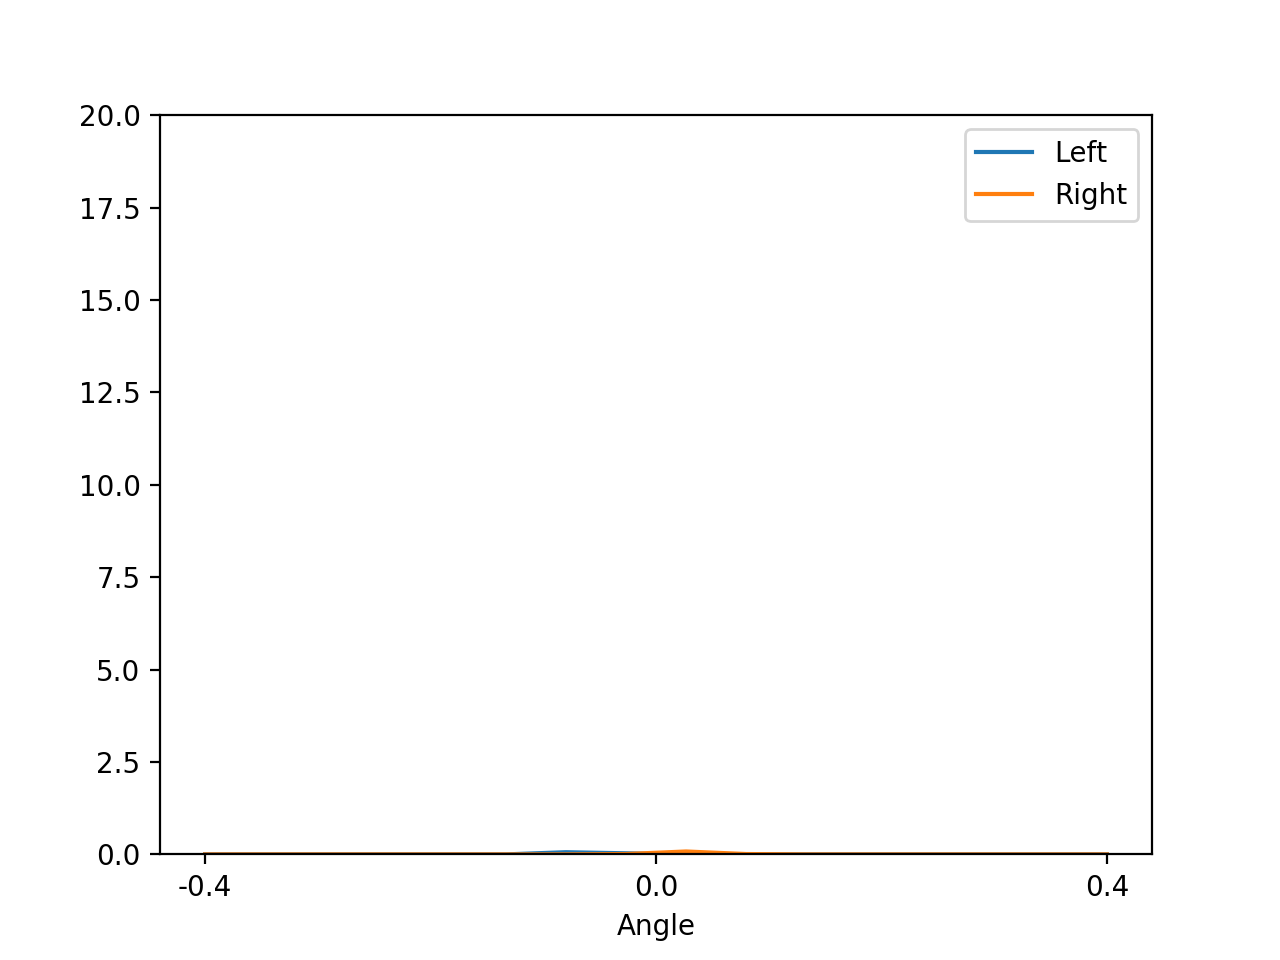

<IPython.core.display.Javascript object>


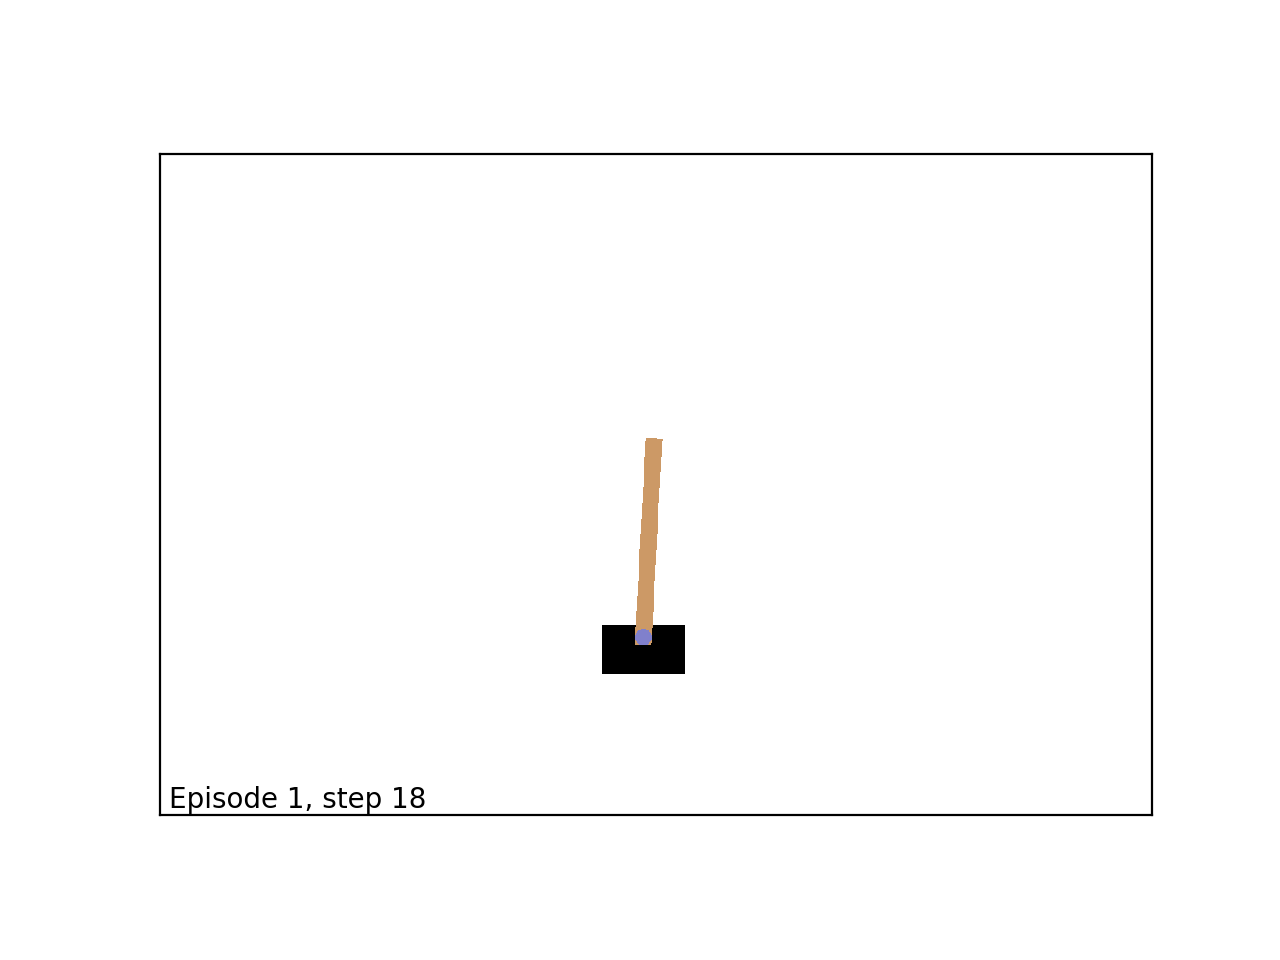

In [72]:
#割引率
gamma = 0.95
#学習率
alpha = 0.01

# 行動価値関数（Qテーブル）
Q = np.zeros([16, 2])

_discretize = lambda x: discretize(x[2], low=-0.4, high=0.4, num=Q.shape[0])
state = _discretize(env.reset())

fig = plt.figure('行動価値関数')
line0, = plt.plot(Q[:,0], label='Left')
line1, = plt.plot(Q[:,1], label='Right')
plt.xlabel('Angle')
plt.xticks([0,7.5,15], [-0.4,0.,0.4])
plt.ylim([0, 1./(1-gamma)])
plt.legend()

episode = 1
t = 0

def step():
    global Q, state, episode, t
    q = Q[state]
    action = epsilon_greedy(q, 0.2)
    next_state, reward, done, _ = env.step(action)
    next_state = _discretize(next_state)
    
    # 行動価値関数の更新
    td = reward + gamma * np.max(Q[next_state]) - Q[state, action]
    Q[state, action] = Q[state, action] + alpha * td
    state = next_state
    
    t += 1
    if done:
        # 環境を初期化する直前の状態と初期化後の状態とは因果関係がないので注意
        state = _discretize(env.reset())
        episode += 1
        t = 0
        
    line0.set_ydata(Q[:,0])
    line1.set_ydata(Q[:,1])
    return 'Episode {}, step {}'.format(episode, t)

run_simulation(env, step)

## 離散4変数版

<IPython.core.display.Javascript object>


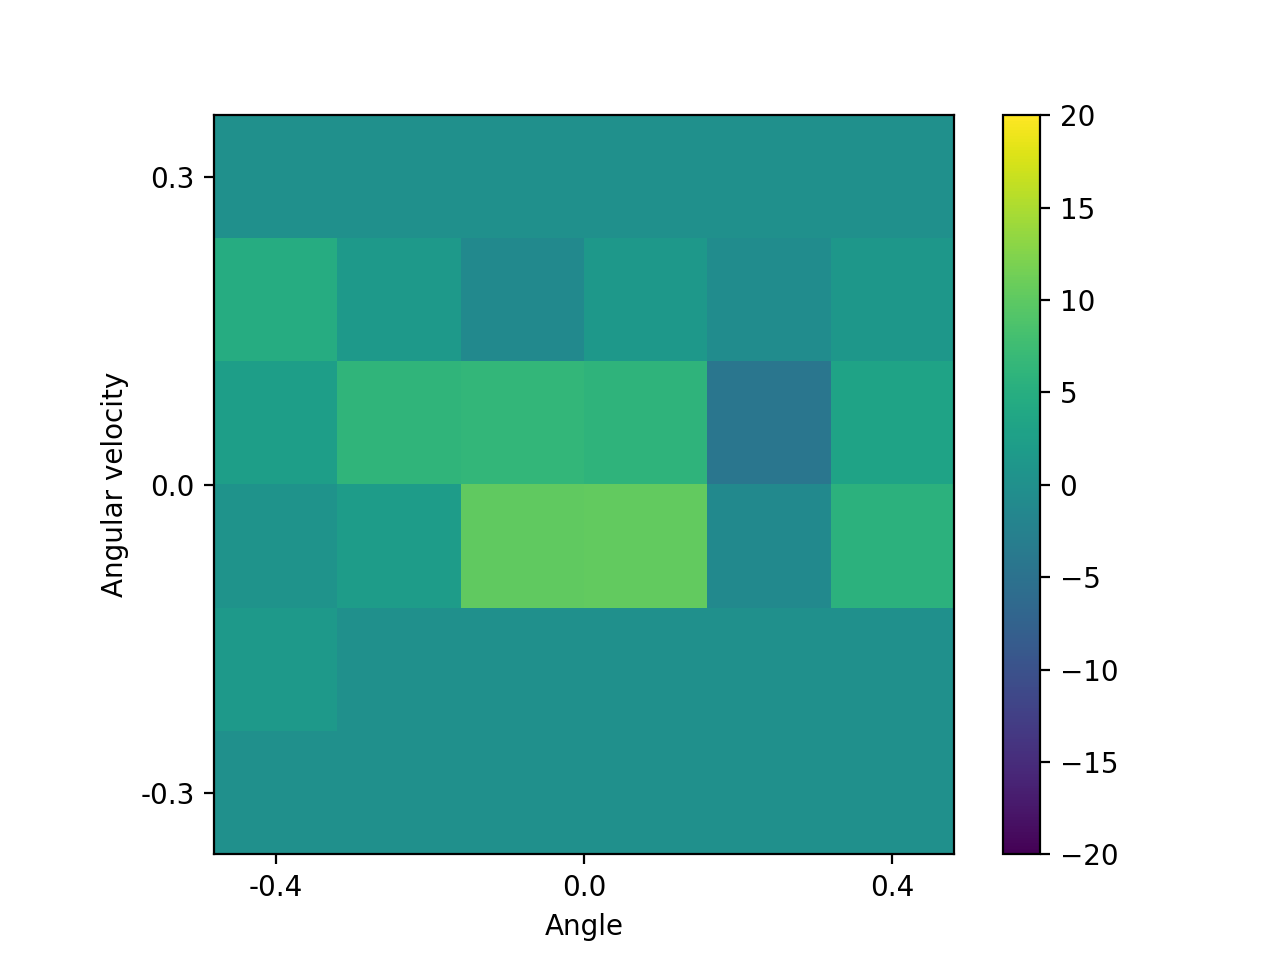

<IPython.core.display.Javascript object>


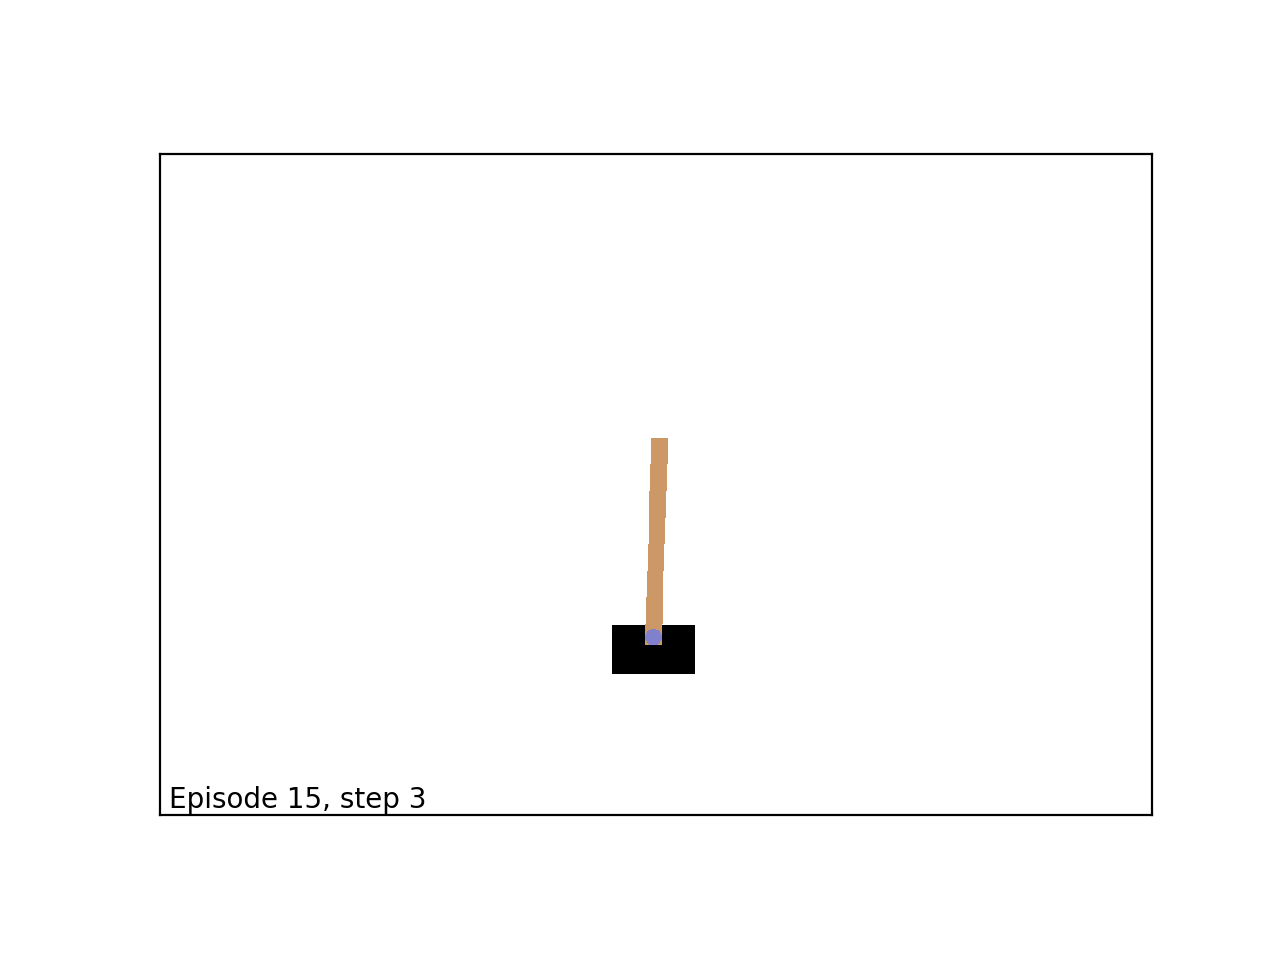

In [29]:
#割引率
gamma = 0.95
#学習率
alpha = 0.05

# 行動価値関数（Qテーブル）
Q = np.zeros([1,1,6,6,2]) # [台車位置，台車速度，振子角度，振子角速度，行動]

# valを離散化する
def discretize(val, low=[-4.8,-1.,-0.4,-0.3], high=[4.8,1.,0.4,0.3], num=[1,1,10,10]):
    val = np.array(val)
    low = np.array(low)
    high = np.array(high)
    num = np.int32(np.array(num) * np.ones_like(val))
    
    dx = (high-low) / num
    ind = np.int32((val-low)/dx)
    ind = np.maximum(0, ind)
    ind = np.minimum(ind, num-1)
    return tuple(ind)

state = env.reset()
state = discretize(state, num=Q.shape[:-1])

fig = plt.figure('行動価値関数')
im = plt.imshow((Q[:,:,:,:,1]-Q[:,:,:,:,0]).mean(1).mean(0), origin='lower')
plt.xlabel('Angle')
plt.ylabel('Angular velocity')
plt.xticks([0,2.5,5], [-0.4,0.,0.4])
plt.yticks([0,2.5,5], [-0.3,0.,0.3])
plt.clim([-1./(1-gamma),1./(1-gamma)])
plt.colorbar()

episode = 1
t = 0

def step():
    global Q, state, episode, t
    q = Q[state]
    action = epsilon_greedy(q, 0.3)
    next_state, reward, done, _ = env.step(action)
    next_state = discretize(next_state, num=Q.shape[:-1])
    
    # 行動価値関数の更新
    td = reward + gamma * np.max(Q[next_state]) - Q[state+(action,)]
    Q[state+(action,)] = Q[state+(action,)] + alpha * td
    state = next_state
    
    t += 1
    if done:
        # 環境を初期化する直前の状態と初期化後の状態とは因果関係がないので注意
        state = env.reset()
        state = discretize(state, num=Q.shape[:-1])
        episode += 1
        t = 0
        
    im.set_array((Q[:,:,:,:,1]-Q[:,:,:,:,0]).mean(1).mean(0))
    return 'Episode {}, step {}'.format(episode, t)

run_simulation(env, step)

## 変数の保存
以下のセルを実行するとQの値を保存／復元できる．

In [67]:
np.save('q_{}.npy'.format('_'.join(map(str,Q.shape))), Q)

In [71]:
Q = np.load('q_{}.npy'.format('_'.join(map(str,Q.shape))))